#Short-term Forecasting of Renewable Energy Production

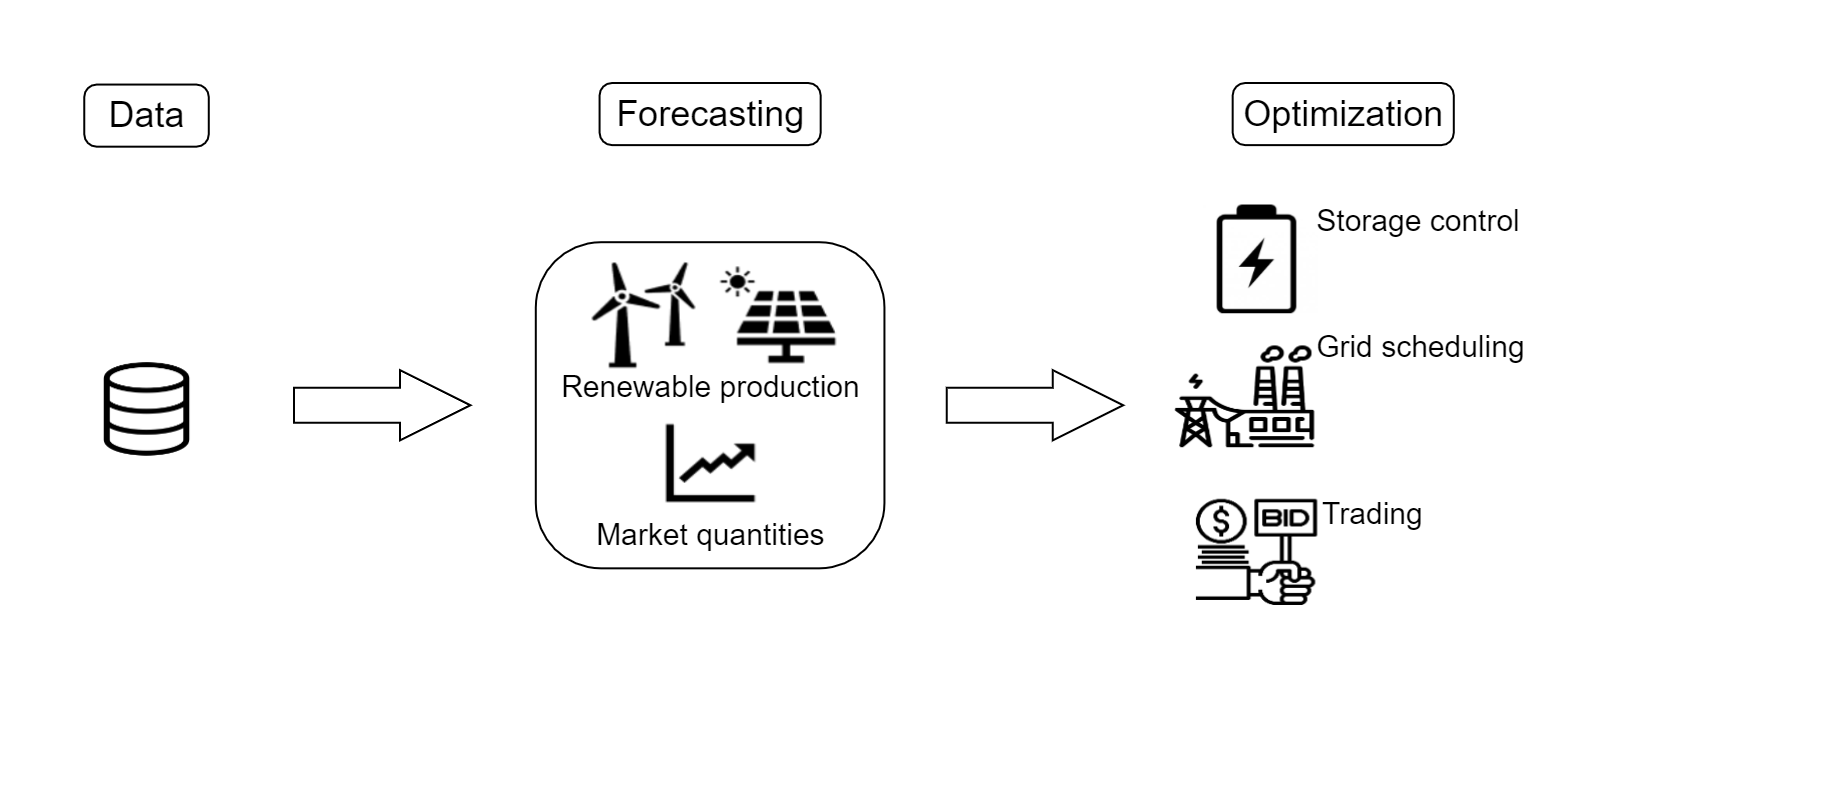

### A few words about me:
* I’m from The Netherlands
* Grew up in Haarlem (near Amsterdam, just like everything else in The Netherlands)
* Did a bachelor in mechanical engineering at the Technical University Delft
* Then a master in sustainable energy technology with a focus on optimal predictive control in EV charging
* Moved to Sweden for a PhD focusing on probabilistic forecasting of solar power and electricity demand
* Currently a postdoc at MINES-Paris in Sophia-Antipolis, France.

Contact details:
```
Dennis van der Meer, PhD
Center PERSEE, MINES Paris-PSL University
mail: dennis.van_der_meer[at]minesparis.psl.eu
```

##Goal

This notebook is meant to give a brief introduction into stochastic processes and various types of forecasts. The focus is mostly on probabilistic forecasts that will serve as input to short-term renewable energy trading. Because these forecasts are a crucial input to many decision-making processes, there has been major interest into this topic from industry and academia.

The goals are:
* Introduce basic concepts of forecasting such as stochastic processes, the types of forecasts and forecast evaluation.
* Introduce feature inspection and feature engineering.
* Apply off-the-shelf forecasting algorithms on publicly available real-world data.

The notebook follows a similar format as the book [Integrating renewables in electricity markets](https://link.springer.com/book/10.1007/978-1-4614-9411-9) by Morales and colleagues and is an excellent starting point if you want to learn more.

## Import necessary libararies

..and define CRPS.

You can drop the cells if you want to have a look but it is not necessary.

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.stats as stats
import math
import scipy

import statsmodels.api as sm

from sklearn import ensemble

# For sliders in plots etc
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Code adapted from properscoring (https://pypi.org/project/properscoring/)

from scipy import special, integrate, stats

from numba import guvectorize


@guvectorize(["void(float64[:], float64[:], float64[:], float64[:])"],
             "(),(n),(n)->()", nopython=True)
def _crps_ensemble_core(observation, forecasts, weights, result):
    # beware: forecasts are assumed sorted in NumPy's sort order

    # we index the 0th element to get the scalar value from this 0d array:
    # http://numba.pydata.org/numba-doc/0.18.2/user/vectorize.html#the-guvectorize-decorator
    obs = observation[0]

    if np.isnan(obs):
        result[0] = np.nan
        return

    total_weight = 0.0
    for n, weight in enumerate(weights):
        if np.isnan(forecasts[n]):
            # NumPy sorts NaN to the end
            break
        if not weight >= 0:
            # this catches NaN weights
            result[0] = np.nan
            return
        total_weight += weight

    obs_cdf = 0
    forecast_cdf = 0
    prev_forecast = 0
    integral = 0

    for n, forecast in enumerate(forecasts):
        if np.isnan(forecast):
            # NumPy sorts NaN to the end
            if n == 0:
                integral = np.nan
            # reset for the sake of the conditional below
            forecast = prev_forecast
            break

        if obs_cdf == 0 and obs < forecast:
            integral += (obs - prev_forecast) * forecast_cdf ** 2
            integral += (forecast - obs) * (forecast_cdf - 1) ** 2
            obs_cdf = 1
        else:
            integral += ((forecast - prev_forecast)
                         * (forecast_cdf - obs_cdf) ** 2)

        forecast_cdf += weights[n] / total_weight
        prev_forecast = forecast

    if obs_cdf == 0:
        # forecast can be undefined here if the loop body is never executed
        # (because forecasts have size 0), but don't worry about that because
        # we want to raise an error in that case, anyways
        integral += obs - forecast

    result[0] = integral

#from ._utils import move_axis_to_end, argsort_indices, suppress_warnings

def move_axis_to_end(array, axis):
    array = np.asarray(array)
    return np.rollaxis(array, axis, start=array.ndim)


def argsort_indices(a, axis=-1):
    """Like argsort, but returns an index suitable for sorting the
    the original array even if that array is multidimensional
    """
    a = np.asarray(a)
    ind = list(np.ix_(*[np.arange(d) for d in a.shape]))
    ind[axis] = a.argsort(axis)
    return tuple(ind)


# The normalization constant for the univariate standard Gaussian pdf
_normconst = 1.0 / np.sqrt(2.0 * np.pi)


def _normpdf(x):
    """Probability density function of a univariate standard Gaussian
    distribution with zero mean and unit variance.
    """
    return _normconst * np.exp(-(x * x) / 2.0)


# Cumulative distribution function of a univariate standard Gaussian
# distribution with zero mean and unit variance.
_normcdf = special.ndtr


def crps_gaussian(x, mu, sig, grad=False):
    """
    Computes the CRPS of observations x relative to normally distributed
    forecasts with mean, mu, and standard deviation, sig.
    CRPS(N(mu, sig^2); x)
    Formula taken from Equation (5):
    Calibrated Probablistic Forecasting Using Ensemble Model Output
    Statistics and Minimum CRPS Estimation. Gneiting, Raftery,
    Westveld, Goldman. Monthly Weather Review 2004
    http://journals.ametsoc.org/doi/pdf/10.1175/MWR2904.1
    Parameters
    ----------
    x : scalar or np.ndarray
        The observation or set of observations.
    mu : scalar or np.ndarray
        The mean of the forecast normal distribution
    sig : scalar or np.ndarray
        The standard deviation of the forecast distribution
    grad : boolean
        If True the gradient of the CRPS w.r.t. mu and sig
        is returned along with the CRPS.
    Returns
    -------
    crps : scalar or np.ndarray or tuple of
        The CRPS of each observation x relative to mu and sig.
        The shape of the output array is determined by numpy
        broadcasting rules.
    crps_grad : np.ndarray (optional)
        If grad=True the gradient of the crps is returned as
        a numpy array [grad_wrt_mu, grad_wrt_sig].  The
        same broadcasting rules apply.
    """
    x = np.asarray(x)
    mu = np.asarray(mu)
    sig = np.asarray(sig)
    # standadized x
    sx = (x - mu) / sig
    # some precomputations to speed up the gradient
    pdf = _normpdf(sx)
    cdf = _normcdf(sx)
    pi_inv = 1. / np.sqrt(np.pi)
    # the actual crps
    crps = sig * (sx * (2 * cdf - 1) + 2 * pdf - pi_inv)
    if grad:
        dmu = 1 - 2 * cdf
        dsig = 2 * pdf - pi_inv
        return crps, np.array([dmu, dsig])
    else:
        return crps

def crps_ensemble(observations, forecasts, weights=None, issorted=False,
                  axis=-1):
    """
    Calculate the continuous ranked probability score (CRPS) for a set of
    explicit forecast realizations.
    The CRPS compares the empirical distribution of an ensemble forecast
    to a scalar observation. Smaller scores indicate better skill.
    CRPS is defined for one-dimensional random variables with a probability
    density $p(x)$,
    .. math::
        CRPS(F, x) = \int_z (F(z) - H(z - x))^2 dz
    where $F(x) = \int_{z \leq x} p(z) dz$ is the cumulative distribution
    function (CDF) of the forecast distribution $F$ and $H(x)$ denotes the
    Heaviside step function, where $x$ is a point estimate of the true
    observation (observational error is neglected).
    This function calculates CRPS efficiently using the empirical CDF:
    http://en.wikipedia.org/wiki/Empirical_distribution_function
    The Numba accelerated version of this function requires time
    O(N * E * log(E)) and space O(N * E) where N is the number of observations
    and E is the size of the forecast ensemble.
    The non-Numba accelerated version much slower for large ensembles: it
    requires both time and space O(N * E ** 2).
    Parameters
    ----------
    observations : float or array_like
        Observations float or array. Missing values (NaN) are given scores of
        NaN.
    forecasts : float or array_like
        Array of forecasts ensemble members, of the same shape as observations
        except for the axis along which CRPS is calculated (which should be the
        axis corresponding to the ensemble). If forecasts has the same shape as
        observations, the forecasts are treated as deterministic. Missing
        values (NaN) are ignored.
    weights : array_like, optional
        If provided, the CRPS is calculated exactly with the assigned
        probability weights to each forecast. Weights should be positive, but
        do not need to be normalized. By default, each forecast is weighted
        equally.
    issorted : bool, optional
        Optimization flag to indicate that the elements of `ensemble` are
        already sorted along `axis`.
    axis : int, optional
        Axis in forecasts and weights which corresponds to different ensemble
        members, along which to calculate CRPS.
    Returns
    -------
    out : np.ndarray
        CRPS for each ensemble forecast against the observations.
    References
    ----------
    Jochen Broecker. Chapter 7 in Forecast Verification: A Practitioner's Guide
        in Atmospheric Science. John Wiley & Sons, Ltd, Chichester, UK, 2nd
        edition, 2012.
    Tilmann Gneiting and Adrian E. Raftery. Strictly proper scoring rules,
        prediction, and estimation, 2005. University of Washington Department of
        Statistics Technical Report no. 463R.
        https://www.stat.washington.edu/research/reports/2004/tr463R.pdf
    Wilks D.S. (1995) Chapter 8 in _Statistical Methods in the
        Atmospheric Sciences_. Academic Press.
    """
    observations = np.asarray(observations)
    forecasts = np.asarray(forecasts)
    if axis != -1:
        forecasts = move_axis_to_end(forecasts, axis)

    if weights is not None:
        weights = move_axis_to_end(weights, axis)
        if weights.shape != forecasts.shape:
            raise ValueError('forecasts and weights must have the same shape')

    if observations.shape not in [forecasts.shape, forecasts.shape[:-1]]:
        raise ValueError('observations and forecasts must have matching '
                         'shapes or matching shapes except along `axis=%s`'
                         % axis)

    if observations.shape == forecasts.shape:
        if weights is not None:
            raise ValueError('cannot supply weights unless you also supply '
                             'an ensemble forecast')
        return abs(observations - forecasts)

    if not issorted:
        if weights is None:
            forecasts = np.sort(forecasts, axis=-1)
        else:
            idx = argsort_indices(forecasts, axis=-1)
            forecasts = forecasts[idx]
            weights = weights[idx]

    if weights is None:
        weights = np.ones_like(forecasts)

    return _crps_ensemble_core(observations, forecasts, weights)

## Load the data we're going to work with today

These data come from the [Global Energy Forecasting Competition 2014](http://www.drhongtao.com/gefcom/2014) and are publicly available. 

There are tracks for wind power, solar power and electricity demand. We'll focus on wind power in this presentation.

In [ ]:
url = "https://drive.google.com/file/d/1xjFJFZkr45HMT02omrn33H4On33GLQJ0/view?usp=sharing"
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url, on_bad_lines="skip")
print(df.head())

   ZONEID      TIMESTAMP  TARGETVAR       U10       V10      U100      V100
0       1  20120101 1:00   0.000000  2.124600 -2.681966  2.864280 -3.666076
1       1  20120101 2:00   0.054879  2.521695 -1.796960  3.344859 -2.464761
2       1  20120101 3:00   0.110234  2.672210 -0.822516  3.508448 -1.214093
3       1  20120101 4:00   0.165116  2.457504 -0.143642  3.215233 -0.355546
4       1  20120101 5:00   0.156940  2.245898  0.389576  2.957678  0.332701


Note that U10 is the wind speed (m/s) due east measured at 10 m altitude and that V10 is the wind speed due north measured at 10 m altitude.

In [ ]:
date_time = pd.to_datetime(df.pop('TIMESTAMP'), format='%Y-%m-%d %H:%M:%S')

## Introduction
The installed capacity of renewable energy sources increases rapidly. Since renewable energy production is a stochastic process, we cannot know the exact production in advance. Despite these uncertainties, decisions still need to be made. This morning we'll focus mainly electricity markets but there are other areas where forecasts are relevant such as to estimate feeder loading.

So, what is a forecast actually? Essentially, it is a prediction with a temporal and potentially spatial aspect.

We use the following notation:

*   We are currently at time $t$.
*   We want to forecast a random variable $Y$ at time $t+k$ $→Y_{t+k}$.
*   Random variable $Y$ can be wind power generation, electricity price or electricity demand.
*   Parameter $k$ is called the lead time.

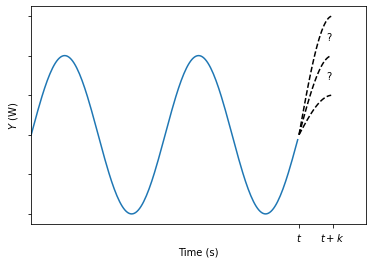

In [ ]:
# Simple forecast example
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

tt = np.arange(2.0, 2.25, 0.01)
s_hi = 1 + 1.5 * np.sin(2 * np.pi * tt)
s_lo = 1 + 0.5 * np.sin(2 * np.pi * tt)
s_mm = 1 + np.sin(2 * np.pi * tt)

fig, ax = plt.subplots()
ax.plot(t, s)
ax.plot(tt, s_hi, linestyle="--", color="black")
ax.plot(tt, s_lo, linestyle="--", color="black")
ax.plot(tt, s_mm, linestyle="--", color="black")

ax.set(xlabel='Time (s)', ylabel=r'$Y$ (W)')
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.xlim([0,2.5])
plt.text(2.20, 2.20, r'?')
plt.text(2.20, 1.70, r'?')

plt.xticks([2, 2.25], ["$t$", "$t+k$"])

plt.show()

### Stochastic processes in one slide
Random variables:
* The materialization of a random variable varies according to a probability mass function (PMF) or probability density function (PDF).
* A discrete random variable is whether it will rain tomorrow, each with a probability (e.g., $\text{P}\{X=\text{rain}\}=0.80$).
* A continuous random variable does not have such clear defined probabilities because $\text{P}\{X=x\}=0 \ \forall \ x$.
* The focus is therefore on the cumulative probability, which gives the definition of a cumulative probability function (CDF): $F(x) = \text{P}\{X \leq x\},\ \forall x$.
* The PDF is the derivative of the CDF: $f(x) = dF/dx, \ \forall x$.

Stochastic processes:
* A multivariate stochastic process can be represented as: $\left\{ Y_{r,s,t} , r=r_1, \ldots, r_m, s=s_1, \ldots, s_n, t=1,\ldots, T\right\}$.
* In words, it is a collection of random variables that describe renewable energy production of $r_m$ renewable energy sources across $s_n$ locations along a sequence of $T$ time steps.
* Lowercase letters are used to denote materializations of the stochastic process:$\left\{ y_{r,s,t} , r=r_1, \ldots, r_m, s=s_1, \ldots, s_n, t=1,\ldots, T\right\}$.

### Definitions and notations

* We want to forecast $Y_{t+k}$ using information available at time $t$. An estimate in statistics is often represented using a 'hat'; $\hat{\cdot}_{t+k|t}$ is an estimate of $Y_{t+k}$.

* At time $t$, we have access to information $\Omega_t$ (training data).

* Using the training data, we need to select a model $g$ and estimate its parameters $\hat{\theta}$.

Most often we're interested in not a single lead time $k$ but a sequence of $k$'s: $k=1,2,\cdots,K$ with regular temporal resolution (e.g., hourly).

## Types of forecasts

### Point forecasts

Remember that $Y_{t+k}$ is a random variable and in our case has a continuous probability distribution. 

A point forecast is the *conditional mean* of the probability distribution we estimate for $Y_{t+k}$ given the information at time $t$ and so:

$\qquad \hat{y}_{t+k|t} = \text{E} \left\{ Y_{t+k} | g, \hat{\theta}, \Omega_t \right\}.$

The conditional mean is our forecast if we use the $\ell_2$-norm as a loss function to find $\hat{\theta}$ (averaged over training data). This is also known as least squares regression.

Below you see a plot of a point forecast with a total lead time $K=48$ h, issued at $t=$ 2018-05-08 00:00 UTC:

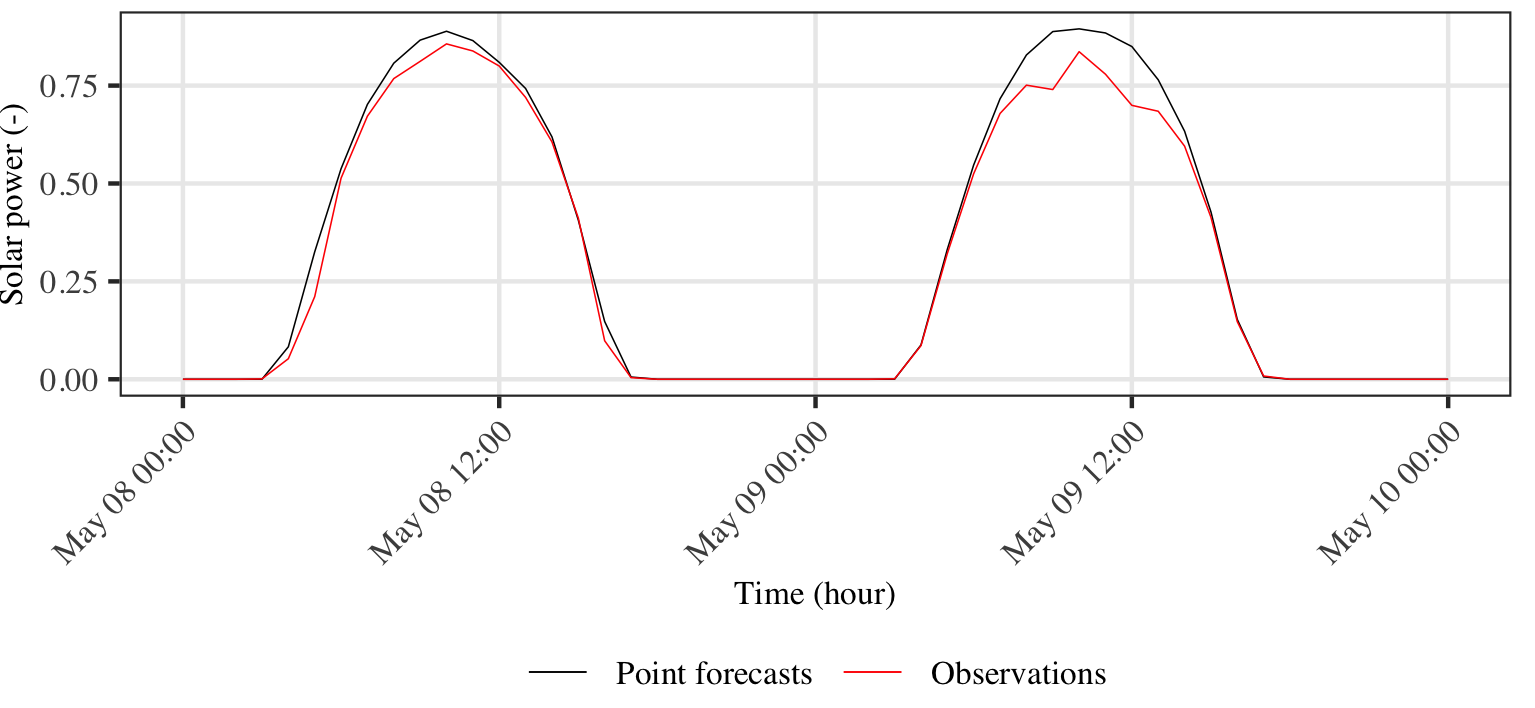

#### Notes on point forecasts

The forecaster seems very confident of his/her prediction, but is that realistic given that it's a forecast for two days in the future?

* Uncertainty arises from many aspects in weather forecasting, which is based on differential equations. For instance, we currently don't model the interaction between every molecule in the atmosphere. 
* Even if we would, we cannot observe each molecule and the initial conditions to the differential equations are therefore approximations. 
* The result is that the same weather forecast model will diverge drastically when given slightly different initial conditions ("dynamical chaos").
* Besides weather, there are uncertainties related to the energy conversion process.

Probabilistic forecasts aim to quantify (at least part of) of the uncertainty so that decision-makers can improve their actions. 

### Probabilistic forecasts -- quantile forecasts

A probabilistic forecast can take many shapes, such as quantiles, prediction intervals, probability density functions or cumulative distribution functions.

A quantile forecast is particularly interesting because:

* It is part of a cumulative distribution function and has a clear probabilistic meaning.
* Like the mean, it is also a point.

A quantile is accompanied with nominal level $\tau \in [0,1]$. In words, a quantile $q^{(\tau)}_t$ gives the magnitude of random variable $Y_t$ when the probability $\tau$ is exceeded. Mathematically:

$\qquad \text{P} \left\{ Y_t \leq y \right\} = \tau \Leftrightarrow q^{(\tau)}_t = F^{-1}_t(\tau)$

In the case of forecasting, issuing $\hat{q}^{(0.90)}_{t+k|t} = 20°\text{C}$ means: "there is a 90\% probability that the temperature will be below $20°\text{C}$".

Below you see a plot that includes the $\hat{q}^{(0.50)}_{t+k|t}$, which is the median.

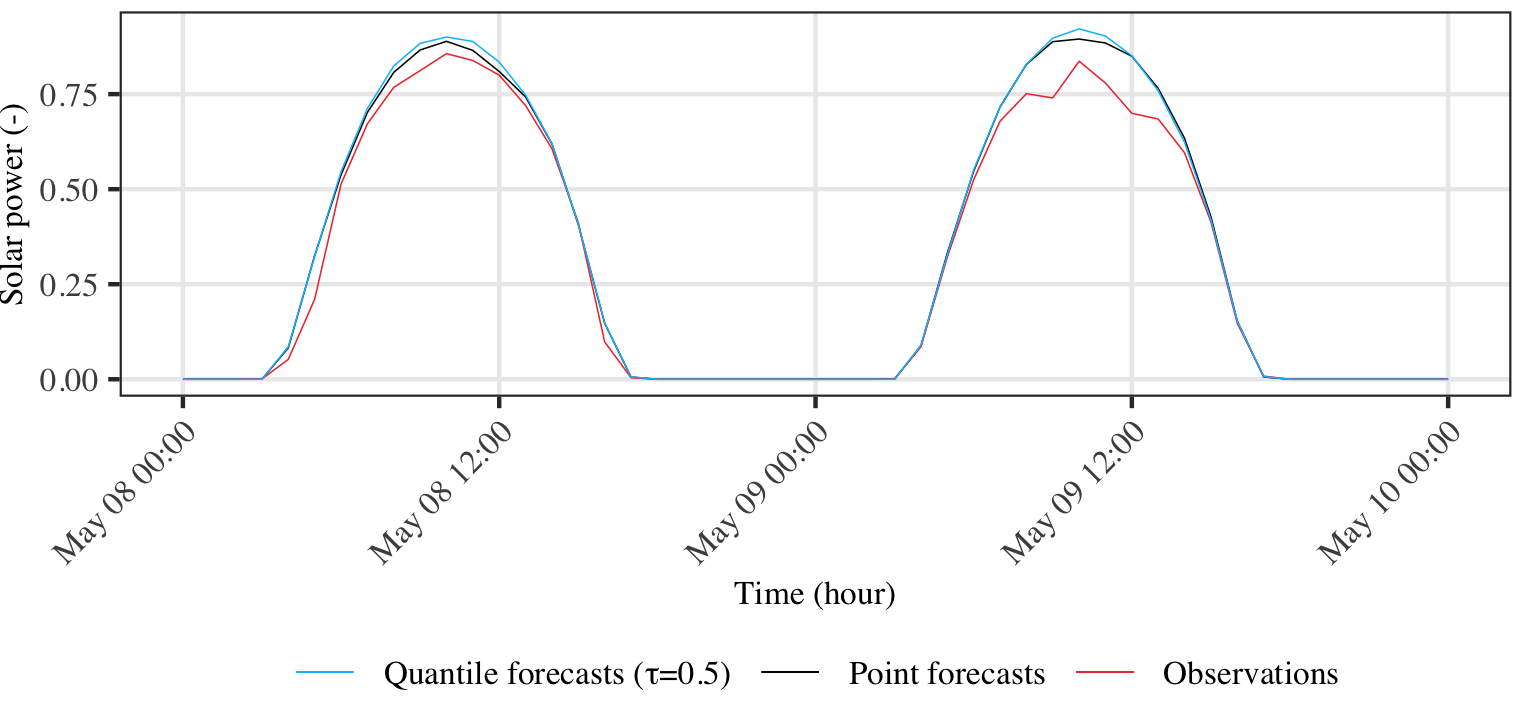

### Probabilistic forecasts -- prediction intervals

A prediction interval $\hat{I}^{(\beta)}_{t+k|t}$ is an extension of a quantile forecast and gives an idea of the *spread* of the forecaster's uncertainty. Essentially, a prediction interval is a set of two quantiles such that there is $(1-\beta)$ probability that random variable $Y_{t+k}$ lies within the interval:

$\qquad \text{P} \left\{ Y_{t+k} \in \hat{I}^{(\beta)}_{t+k|t} |  g, \hat{\theta}, \Omega_t \right\} = 1-\beta$.

The interval forecast can be written as two quantile forecasts as well:

$\qquad \hat{I}^{(\beta)}_{t+k|t} = \left[ \hat{q}_{t+k|t}^{(\tau ̱)}, \hat{q}_{t+k|t}^{(\bar{\tau})} \right]$ and $\bar{\tau} - \tau ̱ = 1-\beta$.

A prediction interval is most commonly centered around the median. Below you see a plot where $1-\beta = 90\%$. 

In words, the forecast says that on May 09 at 12:00 UTC, we forecast that there is a 90% probability that the power production will be between 0.75 and 0.90. At the same time, it says that there is 5% probability that the power production will be lower than 0.75 and 5% probability that the power production will be higher than 0.90.


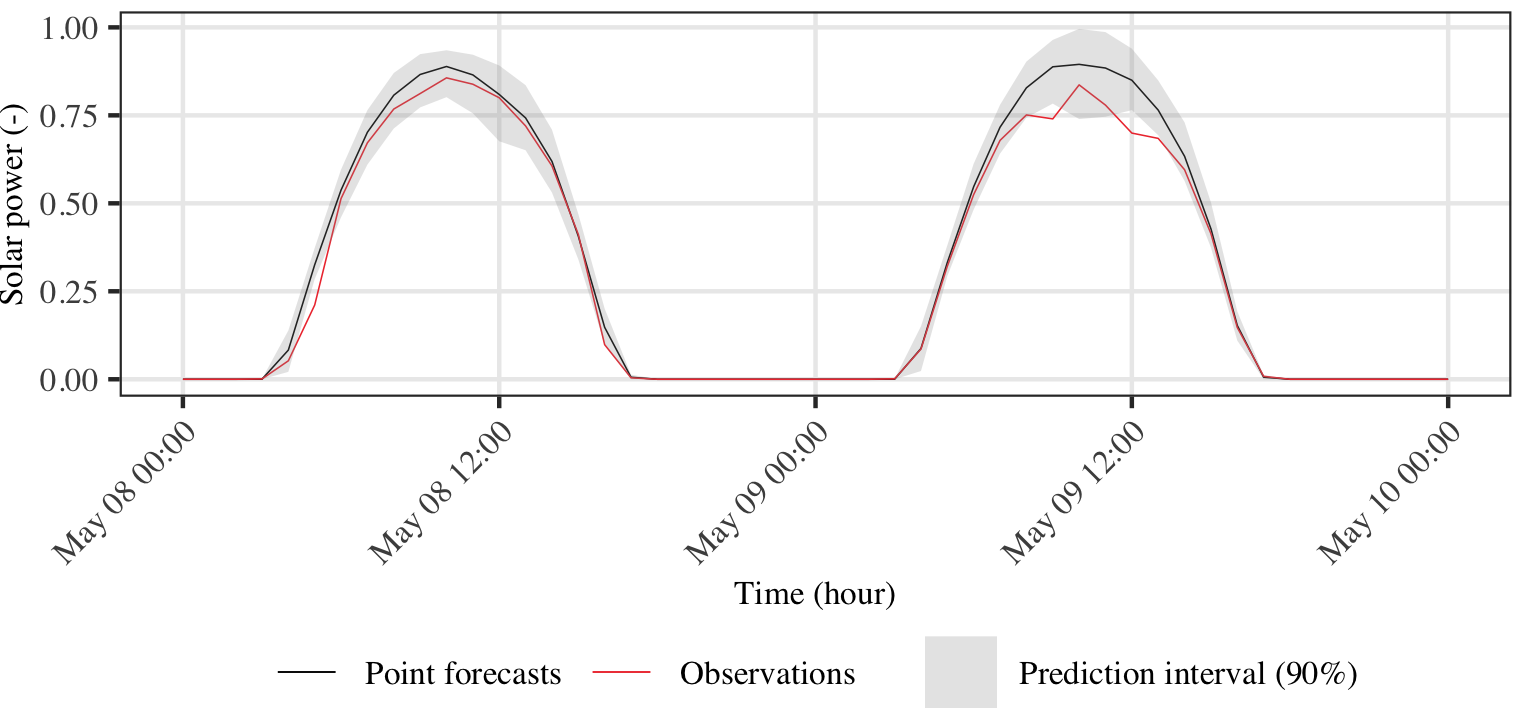

### Probabilistic forecasts -- probability distributions

A logical extension to prediction intervals is simply issuing the entire distribution, either as a probability density function $\hat{f}_{t+k|t}$ or as a cumulative distribution function $\hat{F}_{t+k|t}$.

Recall that the definition of a cumulative distribution function is:

$\qquad F(x) = \text{P}\{X \leq x\}, \quad \forall x,$

and that of a probability density function is:

$\qquad f(x) = \frac{dF}{dx}, \quad \forall x.$

The probabilistic forecast can be generated using parametric or nonparametric approaches:

* Parametric approaches assume a probability distribution (e.g., Gaussian or Beta).
* Nonparametric approaches do not assume a probability distribution and can be based on quantile regression.

We will look in a bit more detail into parametric and nonparametric forecasts later. For now, you can see an example of nonparametric probabilistic forecasts below:

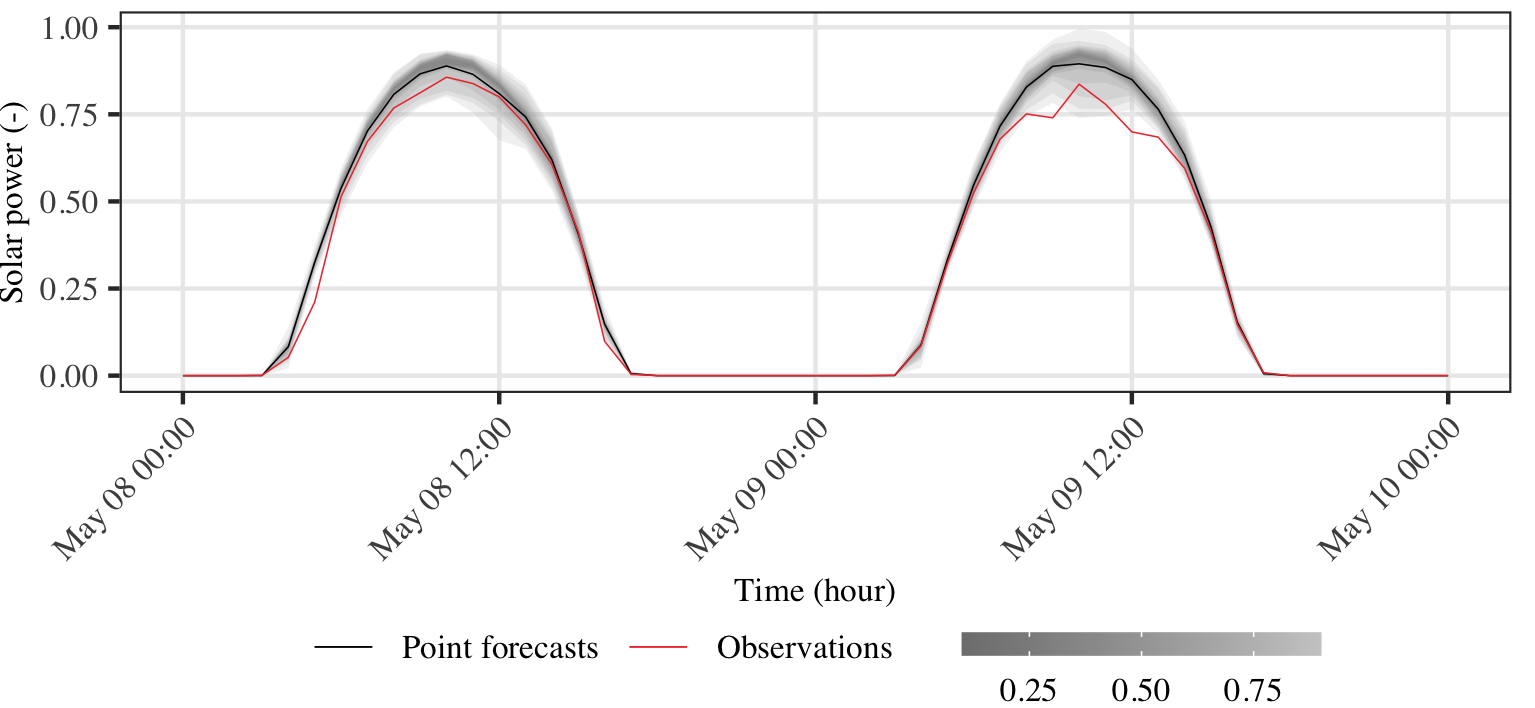

### Probabilistic forecasts -- trajectories

Probabilistic forecasts give an estimate of the uncertainty at a specific $t+k$.

However, especially when it comes to the weather, it is likely that an error at $t+k$ is followed by another (similar) error at $t+k+1$.

This is also important if there are multiple solar power plants or wind turbines close to each other, as well as when these resources are combined.

A number of operational decision-making problems require such information:

* optimal operation of a hybrid power plant, for example a solar power plant with battery storage,
* stochastic unit commitment of zonal generators subject to spatially varying renewable power generation,
* probabilistic power flow simulations of a low-voltage grid to evaluate nodal voltages and line loading.

The plot below shows a forecast with 20 scenarios that aim to approximate the multivariate random variable $\hat{\textbf{Y}}_t = \{ \hat{Y}_{t+1|t}, \ldots, \hat{Y}_{t+K|t} \}$.

We won't go into detail on how to generate trajectory forecasts because the mathematics is a bit more involved, but you can find more information in Section 2.5.4 of the book referenced at the top of this notebook.

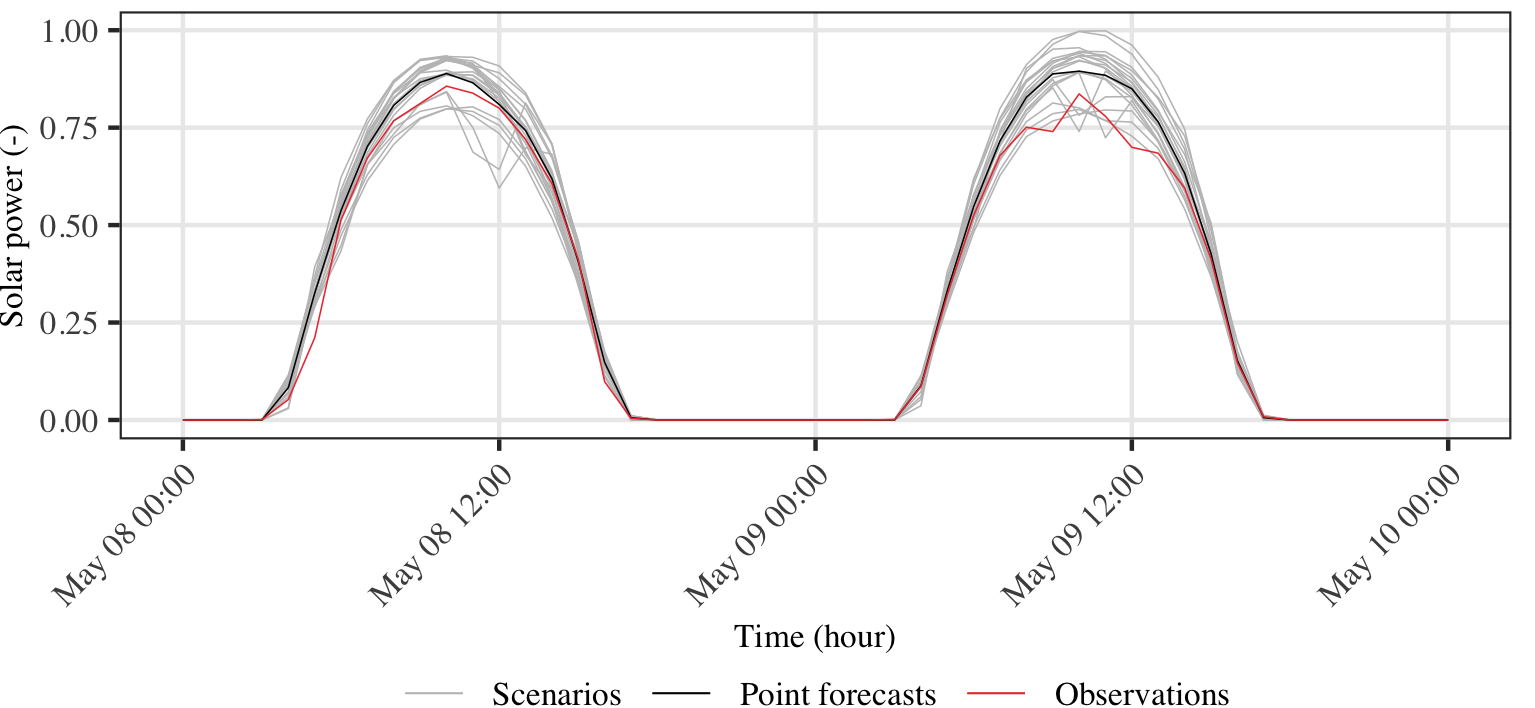

## Generating probabilistic forecasts

### Generating parametric probabilistic forecasts

Parametric probabilistic forecasts have a clear advantage: they are fully described by their parameters $\theta$. The main disadvantage is the assumption that the parametric distribution is often too restrictive.

The assumption translates to:

$\qquad Y_{t+k} \sim F(y; \theta_{t+k})$.

The forecast therefore becomes:

$\qquad \hat{F}_{t+k|t} \sim F(y; \hat{\theta}_{t+k|t})$,

and the set of parameters $\hat{\theta}_{t+k|t}$forecast is therefore actually to be forecast.

Below you'll see two parametric probabilistic forecasts 
* A Gaussian distribution with $\hat{\mu}_{t+k|t}=25\%$ and $\hat{\sigma}_{t+k|t}=2\%$,
* A Beta distribution with $\hat{\alpha}_{t+k|t}=2.09$ and $\hat{\beta}_{t+k|t}=6.28$.

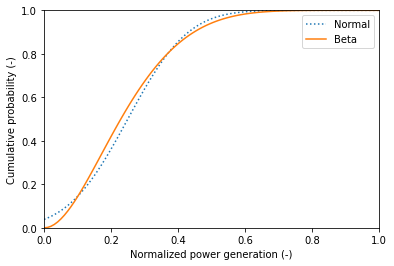

In [ ]:
# Generate synthetic parametric probabilistic forecasts
mu = 0.25; variance = 0.02; sigma = math.sqrt(variance)
alpha = 2.09; beta = 6.28
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
plt.xlim([0,1])
plt.ylim([0,1])
ax.plot(x, stats.norm.cdf(x, mu, sigma), linestyle=':', label='Normal')
ax.plot(x, stats.beta.cdf(x, alpha, beta), linestyle='-', label='Beta')
plt.legend()
ax.set(xlabel='Normalized power generation (-)', ylabel=r'Cumulative probability (-)')
plt.show()

### Generating nonparametric probabilistic forecasts

Most often, we don't know the true data generating process and the parametric assumption can become unrealistic when evaluated over a longer period of time.

The nonparametric approach instead approximates the distribution $F$ using $Q$ quantiles that we saw before. Essentially, we assume that:

$\qquad Y_{t+k} \sim F_{t+k}$.

The forecast (summarized by the $Q$ quantiles) is then:

$\qquad \hat{F}_{t+k|t} = \{ \hat{q}_{t+k|t}^{(\tau_i)}, 0 \leq \tau_1 < \cdots < \tau_i < \cdots < \tau_Q \leq 1 \} $.

A common choice for $Q$ is 19, which means that $\tau_i \in \{ 0.05, 0.10, \ldots, 0.95 \}$. 

There are several ways to attain the probabilities in the interval such as linear interpolation or monotone Hermite spline interpolation. The tails are difficult to estimate because the data there are sparse by definition. They can be attained through linear extrapolation or by assuming an exponential shape.

Below you'll see a synthetic nonparametric probabilistic forecasts with linear inter- and extrapolation.

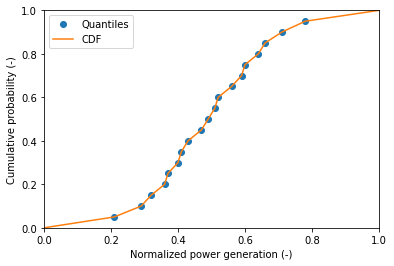

In [ ]:
# Generate a synthetic forecast
taus = np.linspace(0.05, 0.95, 19)
quants = np.array([0.21, 0.29, 0.32, 0.36, 0.37, 0.40, 0.41, 0.43, 0.47, 0.49,
                  0.51, 0.52, 0.56, 0.59, 0.60, 0.64, 0.66, 0.71, 0.78])

F = scipy.interpolate.interp1d(quants,taus, fill_value=(0,1), bounds_error=False)
fig, ax = plt.subplots()
plt.xlim([0,1])
plt.ylim([0,1])
ax.plot(quants, taus, 'o', label='Quantiles')
ax.plot(np.insert(quants, [0,len(quants)], [0,1]), F(np.insert(quants, [0,len(quants)], [0,1])), linestyle='-', label='CDF')
plt.legend()
ax.set(xlabel='Normalized power generation (-)', ylabel=r'Cumulative probability (-)')
plt.show()

## Forecast evaluation

### Point forecast evaluation

An important question in forecasting is whether the forecasts (point, probabilistic or trajectory) are any good. For that, we first have to establish what a ''good'' forecast actually is.

There are three aspects to a good forecast: 

* Consistency,
* Quality, and
* Value.

In this part, we'll focus on quality but Akylas will talk more about the value of probabilistic forecasts. Also, the focus in this presentation is on probabilistic forecasting so we'll only look at the most commonly used scores: 

* Forecast error $\epsilon_{t+k|t} = \hat{y}_{t+k|t} - y_{t+k}$,

* Mean bias error (MBE): $\text{MBE}(t+k) = \frac{1}{T} \sum_{t=1}^{T} \epsilon_{t+k|t}$,

* Root mean squared error (RMSE): $\text{RMSE}(t+k) = \sqrt{\frac{1}{T} \sum_{t=1}^{T} (\epsilon_{t+k|t})^2}$,

* Mean absolute error (MAE): $\text{MAE}(t+k) = \frac{1}{T} \sum_{t=1}^{T} |\epsilon_{t+k|t}|$.



### Probabilistic forecast verification

Probabilistic forecast verification is more involved because the quality isn't just about how far the forecast is from the observation, but also whether the forecast is statistically of high quality.

* The first aspect of quality is *reliability* or *calibration* and means that the forecasts should approximate the probability distribution of the observations. We can evaluate this using the probability integral transform:

$\qquad \hat{F}_{t+k|t}(Y_{t+k|t}) \sim U[0,1]$,

$\qquad$ In words: reliable probabilistic forecasts have an approximately *flat* histogram of probability integral transform variables. Any deviation 
$\qquad$from "flatness" is called *miscalibration*.

* Another important aspect is the sharpness or the width of the predictive distribution.

* The continuous ranked probability score (CRPS) is a score that evaluates both reliability and sharpness:

$\qquad \text{CRPS}(t+k) = \frac{1}{T} \sum_{t=1}^T \int_{-\infty}^{\infty} \left( \hat{F}_{t+k|t}(x) - 1\{ x \geq y_{t+k} \} \right)^2 dx$

Below you see an interactive plot to showcase the different types of miscalibration:

In [ ]:
def plot(mu_f, sigma_f):
  np.random.seed(123)
  mu_o = 0    # Mean of the observations
  sigma_o = 1 # Standard deviation of the observations
  obs = np.random.normal(mu_o, sigma_o, size=10000) # Sample observations
  F = stats.norm.cdf(obs, mu_f, sigma_f) # Compute probability integral transform

  # Plot results
  fig = plt.figure(figsize=(8,8))
  gs = gridspec.GridSpec(3, 3)
  ax_main = plt.subplot(gs[1:3, :2], xlim=(-4,4))
  ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
  ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

  ax_main.plot(np.sort(obs),np.sort(F),'k--', linewidth=1.5, label='Probabilistic forecasts')
  ax_main.vlines(mu_f, ymin=0, ymax=1, label='Mean forecast')
  ax_main.legend(loc='best')

  ax_xDist.hist(obs,bins=100,align='mid')
  ax_xDist.set(ylabel='count')

  ax_yDist.hist(F,bins=100,orientation='horizontal',align='mid')
  ax_yDist.set(xlabel='count')

  ax_main.text(1.75, 0.15, r'CRPS ='+str(np.around(np.mean(crps_gaussian(obs, mu_f, sigma_f)), decimals=3)))

  plt.show()

In [ ]:
interact(plot, 
         mu_f = widgets.FloatSlider(min=-2, max=2, step=0.5, value=0), 
         sigma_f = widgets.FloatSlider(min=0.5, max=1.5, step=0.25, value=1))

interactive(children=(FloatSlider(value=0.0, description='mu_f', max=2.0, min=-2.0, step=0.5), FloatSlider(val…

<function __main__.plot>

## Data inspection and feature engineering

### Inspecting the available data

Recall that all information until time $t$ is contained in $\Omega_t$. In fact, $\Omega_t$ itself comprises several data sources such as weather forecasts (exogenous), remote sensing data (exogenous) or observations (endogenous). Let $\Psi_t$ contain the set of endogenous data:

$\qquad \Psi_t = \{ y_t, y_{t-1}, \ldots, u_t, u_{t-1}, \ldots, \omega_t, \omega_{t-1}, \ldots \}$,

and $\Gamma_t$ the set of exogenous data:

$\qquad \Gamma_t = \{ \hat{u}_{t+1|t}, \hat{u}_{t+2|t}, \ldots, \hat{u}_{t+K|t}, \hat{\omega}_{t+1|t}, \hat{\omega}_{t+2|t}, \ldots, \hat{\omega}_{t+K|t} \}$.

In essence, a forecaster aims to train a linear or nonlinear function that establishes a meaningful relationship between the observations and the data sources or a subset thereof.

Now that we have defined the data, let's see how some of the variables evolve over time:

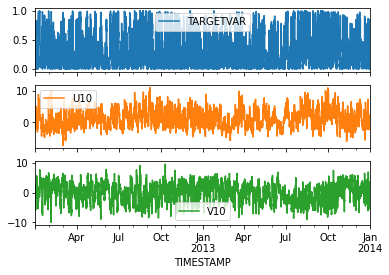

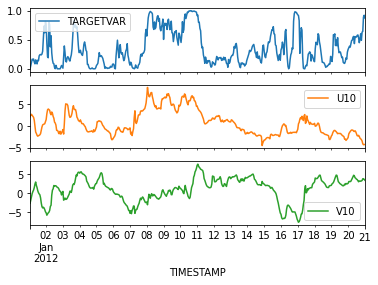

In [ ]:
plot_cols = ['TARGETVAR', 'U10', 'V10']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

We can also look into the relationship between features:

(-7.494251962, 11.11702926, -9.993858366, 9.508797882)

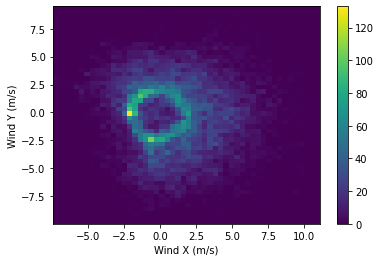

In [ ]:
plt.hist2d(df['U10'], df['V10'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Wind X (m/s)')
plt.ylabel('Wind Y (m/s)')
ax = plt.gca()
ax.axis('tight')

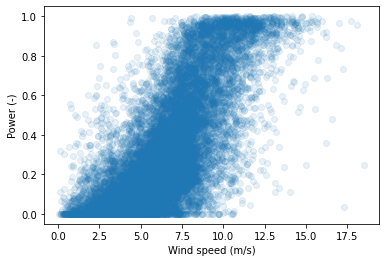

In [ ]:
# Show the nonlinear relationship between wind power and wind speed
wind_speed = np.sqrt(df['U100'].values**2 + df['V100'].values**2)
plt.scatter(wind_speed, df['TARGETVAR'].values, alpha=.1)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (-)')
plt.show()

Besides plotting the data, we might also want to have a look at the statistics to see if there are any anomalies:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ZONEID,17544.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TARGETVAR,17526.0,0.301127,0.288693,0.000000,0.062682,0.204492,0.475284,1.000000
U10,17544.0,0.938364,2.557779,-7.494252,-1.059759,0.787009,2.587685,11.117029
V10,17544.0,-0.215083,2.905387,-9.993858,-2.297150,0.008804,1.946403,9.508798
U100,17544.0,1.565958,4.261868,-10.910809,-1.744488,1.478870,4.672329,16.988418
V100,17544.0,-0.499108,5.003975,-15.294866,-4.502398,0.207761,3.501735,14.314416


In [ ]:
# We can remove the zone ID column because it doesn't contain any useful information
df.drop(columns='ZONEID', inplace=True)

### Feature engineering

Arguably one of the most important aspects of forecasting is feature engineering.

Since we are dealing with weather variables as a time series, it can be useful to feed information regarding the periodicity to the model.

For example, we can extract a daily cycle and a yearly cycle from the time vector:

In [ ]:
# Convert pandas time stamps to seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [ ]:
day = 24*60*60 # s
year = (365.2425)*day
# Add features to df:
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

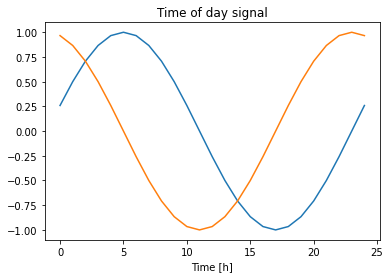

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

If you do not know what frequencies are important, you can determine these using Fast Fourier Transform (FFT). You can see there are two peaks close to the daily and yearly frequency points:

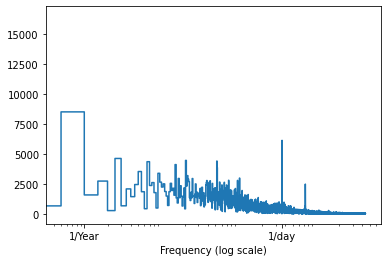

In [ ]:
fft = tf.signal.rfft(df['U10'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['TARGETVAR'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Other features that can hold relevant information are the raw recent observations and the moving average and the moving standard deviation of the recent observations (or other features).

The team that won the GEFCom 2014 wind power track actually engineered many more features. Moreover, they used information from adjacent zones to inform their forecast model.

You can read more [here](https://reader.elsevier.com/reader/sd/pii/S0169207016000145?token=72C00273B1BF1D019FBD441BFB1BDE15711178BCBCD4497AAD0B6EB52992A8C021D8A66FF3A8451892A5C7D6777CF11D&originRegion=eu-west-1&originCreation=20220217072626) if you're interested.

In [ ]:
# Forecast horizon is 24 hours:
k = 24

# Add features to df:
df['Moving average'] = df['TARGETVAR'].rolling(window=k).mean()
df['Moving sd'] = df['TARGETVAR'].rolling(window=k).std()
df['Lag'] = df['TARGETVAR'].shift(periods=k)

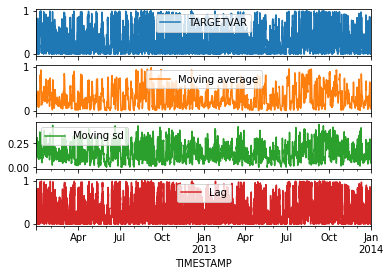

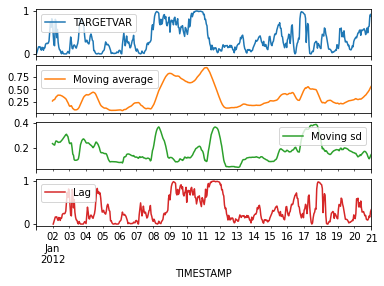

In [ ]:
plot_cols = ['TARGETVAR', 'Moving average', 'Moving sd', 'Lag']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Notice that we introduced missing values when computing the moving average. Also, there may be missing data in the original data set. We could interpolate or impute these data but here we remove all rows that contain a missing data point for simplicity.

In [ ]:
idx_nan = df.isnull().any(axis=1)
date_time = date_time[-idx_nan]
df = df.loc[-idx_nan,:]

### Data preparation

Next, we'll split the data into training and testing sets. Normally, we'd include a validation set to verify that any hyperparameters in our model are accurate but we ignore that here for simplicity.

A common split for training, validation and testing is 70%, 20% and 10%, respectively. But, this depends on the amount of available data; if there are millions and millions of observations, the testing set could relatively be made much smaller. 

However, we're dealing with time series and so it is desirable to have at least one year of testing to capture seasonalities etc., so we opt for a 50%-50% split here.

Unlike classification or other prediction tasks, we won't shuffle the data because of the natural ordering of time series. 

In [ ]:
n = len(df)
train_df = df[0:int(n*0.5)]
test_df = df[int(n*0.5):]
test_time = date_time[int(n*0.5):]

num_features = df.shape[1]

It is also common to normalize the features, which is especially important for models that multiply features with learned parameters (e.g., linear regression or neural networks).

Normalization can be done using Min-Max scaling or standardization, the latter of which we'll use here. We subtract of each feature its mean and divide it by its standard deviation.

Important! Use the mean and standard deviation from the training data because in an operational setting we do not have access to validation and testing data.

In [ ]:
# First, extract the observations (training and testing labels)
train_labels = train_df.pop('TARGETVAR')
test_labels = test_df.pop('TARGETVAR')

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now we can plot the distribution of the features. Note that most of them are centered quite nicely around 0 although they are not all symmetric. This could mean that there are some differences between the training set and the rest of the data set.

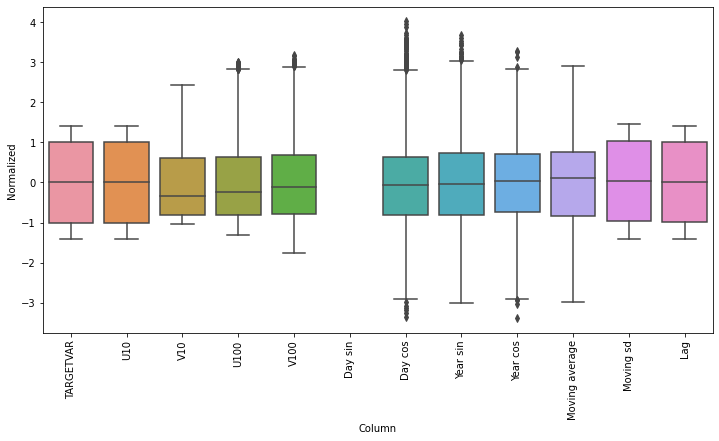

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Generating probabilistic forecasts

Recall that we need three parts to generate a (probabilistic) forecast:

* A model $g$,
* Parameters $\theta$, and
* Information set $\Omega$ which comprises endogenous data $\Psi$ and exogenous forecasts $\Gamma$.

When developing a new model, it is common to benchmark it against tried and tested models. A forecast model without skill is persistence, which is just saying that $\hat{y}_{t+k|t} = y_t$. A similar benchmark for probabilistic forecasts would be climatology $\hat{F}_{t+k|t} = \{y_1,\ldots,y_t\}$.

The next model we can consider is ordinary least squares (OLS) and use the training error as a Gaussian probability distribution around the mean prediction, we'll do this below. 

Note that we add a constant for ```statsmodels```.

### Ordinary least squares

In [ ]:
TAUS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
%%time
Train_df = sm.add_constant(train_df)
Test_df = sm.add_constant(test_df)

# Fit an ols model
ols = sm.OLS(train_labels, Train_df).fit()

CPU times: user 21.1 ms, sys: 4.17 ms, total: 25.3 ms
Wall time: 38.6 ms


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
def ols_quantile(m, X, tau):
    # m: OLS model.
    # X: Feature matrix.
    # tau: Nominal probability level.

    # Set alpha based on tau. Vectorized for different values of tau.
    mean_pred = m.predict(X)
    se = np.sqrt(m.scale)
    return mean_pred + stats.norm.ppf(tau) * se

In [ ]:
fcs_ols = np.column_stack( [ols_quantile(ols, Test_df, tau) for tau in TAUS] )

In [ ]:
# Combine the forecasts and observations into a single DF
TAUS.insert(0, 'y')
plot_fcs = pd.DataFrame(data=np.column_stack((test_labels,fcs_ols)),
                        index=test_time,
                        columns=TAUS)

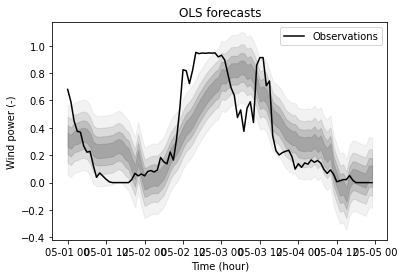

In [ ]:
tmp = plot_fcs.loc['2013-05-01':'2013-05-04']

fig, ax = plt.subplots()

ax.fill_between(tmp.index, tmp[0.9], tmp[0.1], color='grey', alpha=0.1)
ax.fill_between(tmp.index, tmp[0.8], tmp[0.2], color='grey', alpha=0.2)
ax.fill_between(tmp.index, tmp[0.7], tmp[0.3], color='grey', alpha=0.3)
ax.fill_between(tmp.index, tmp[0.6], tmp[0.4], color='grey', alpha=0.4)

ax.plot(tmp.index, tmp['y'], color='black', label='Observations')

plt.legend()

ax.set(xlabel='Time (hour)', ylabel=r'Wind power (-)', title='OLS forecasts')

plt.show()

These forecasts are not too bad; the model seems to predict the trend quite nicely on this period. But, the uncertainty is constant as we can see from the probabilistic forecasts.

Another important point is that the model forecasts there is a probability that the power becomes negative, which is of course impossible. Therefore, it is important to check the forecasts and *postprocess* them if necessary.

Let's see if we can do better with quantile regression, in which quantile of the predictive distributions is forecast separately. This implies more computational burden but generally results in more realistic forecasts.

### Quantile regression

In [ ]:
%%time
TAUS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
quantreg = sm.QuantReg(train_labels, Train_df)
fcs_quantreg = np.column_stack( [quantreg.fit(q=tau).predict(Test_df) for tau in TAUS] ) 

CPU times: user 2.43 s, sys: 1.4 s, total: 3.84 s
Wall time: 1.99 s


In [ ]:
# Combine the forecasts and observations into a single DF
TAUS.insert(0, 'y')
plot_fcs = pd.DataFrame(data=np.column_stack((test_labels,fcs_quantreg)),
                        index=test_time,
                        columns=TAUS)

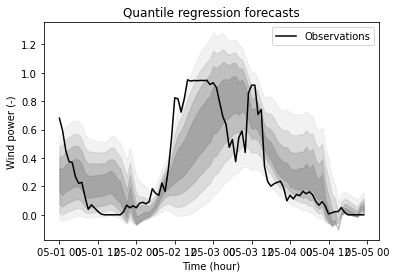

In [ ]:
tmp = plot_fcs.loc['2013-05-01':'2013-05-04']

fig, ax = plt.subplots()

ax.fill_between(tmp.index, tmp[0.9], tmp[0.1], color='grey', alpha=0.1)
ax.fill_between(tmp.index, tmp[0.8], tmp[0.2], color='grey', alpha=0.2)
ax.fill_between(tmp.index, tmp[0.7], tmp[0.3], color='grey', alpha=0.3)
ax.fill_between(tmp.index, tmp[0.6], tmp[0.4], color='grey', alpha=0.4)

ax.plot(tmp.index, tmp['y'], color='black', label='Observations')

plt.legend()

ax.set(xlabel='Time (hour)', ylabel=r'Wind power (-)', title='Quantile regression forecasts')

plt.show()

These forecasts seem a bit more realistic, mainly because the uncertainty varies. However, there are still nonzero probabilities that the power becomes negative at certain time, which needs to be postprocessed. Also, the power exceeds 1.0 with quite a margin, which should also be postprocessed.

Another interesting point is the computation time, which increased quite a bit because we essentially have to estimate a model for each probability level $\tau_i$. This is also important to keep in mind when using such models in an operational setting.

Until now, we've tried models that are linear in the parameters. Now we'll test a nonlinear model based on decision trees.

### Quantile regression forests

In [ ]:
%%time
TAUS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
N_ESTIMATORS = 1000
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.
rf.fit(Train_df, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   44.7s


CPU times: user 1min 43s, sys: 729 ms, total: 1min 43s
Wall time: 56.2 s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   55.6s finished


In [ ]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [ ]:
%%time
fcs_rf = np.column_stack( [rf_quantile(rf, Test_df.values, tau) for tau in TAUS] )

CPU times: user 15.3 s, sys: 238 ms, total: 15.5 s
Wall time: 15.5 s


In [ ]:
# Combine the forecasts and observations into a single DF
TAUS.insert(0, 'y')
plot_fcs = pd.DataFrame(data=np.column_stack((test_labels,fcs_rf)),
                        index=test_time,
                        columns=TAUS)

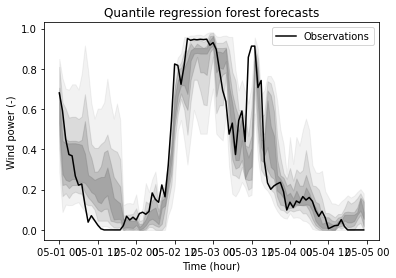

In [ ]:
tmp = plot_fcs.loc['2013-05-01':'2013-05-04']

fig, ax = plt.subplots()

ax.fill_between(tmp.index, tmp[0.9], tmp[0.1], color='grey', alpha=0.1)
ax.fill_between(tmp.index, tmp[0.8], tmp[0.2], color='grey', alpha=0.2)
ax.fill_between(tmp.index, tmp[0.7], tmp[0.3], color='grey', alpha=0.3)
ax.fill_between(tmp.index, tmp[0.6], tmp[0.4], color='grey', alpha=0.4)

ax.plot(tmp.index, tmp['y'], color='black', label='Observations')

plt.legend()

ax.set(xlabel='Time (hour)', ylabel=r'Wind power (-)', title='Quantile regression forest forecasts')

plt.show()

The predictive distributions look much narrower here. This is desirable as long as they are reliable (calibrated)! We'll check this next.

### Forecast verification

We'll use CRPS as a numerical score to quickly compare the forecast models and histograms of the probability integral transform variables to verify whether the forecasts are reliable.

In [ ]:
# Compute CRPS for each model:
print('CRPS of OLS: ' + str(np.around(crps_ensemble(test_labels, fcs_ols).mean(), decimals=3)))
print('CRPS of Quantile regression: ' + str(np.around(crps_ensemble(test_labels, fcs_quantreg).mean(), decimals=3)))
print('CRPS of Quantile regression forests: ' + str(np.around(crps_ensemble(test_labels, fcs_rf).mean(), decimals=3)))

CRPS of OLS: 0.114
CRPS of Quantile regression: 0.105
CRPS of Quantile regression forests: 0.082


In [ ]:
TAUS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
# Compute PIT variables for each model
pit_ols = [scipy.interpolate.interp1d(fcs_ols[i,:],TAUS, fill_value=(0,1), bounds_error=False)(test_labels.iloc[i]) for i in range(len(test_labels))]
pit_quantreg = [scipy.interpolate.interp1d(fcs_quantreg[i,:],TAUS, fill_value=(0,1), bounds_error=False)(test_labels.iloc[i]) for i in range(len(test_labels))]
pit_rf = [scipy.interpolate.interp1d(fcs_rf[i,:],TAUS, fill_value=(0,1), bounds_error=False)(test_labels.iloc[i]) for i in range(len(test_labels))]

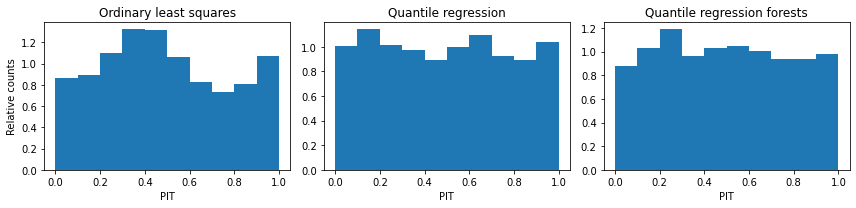

In [ ]:
n_bins = 10

fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

ax0.hist(pit_ols, n_bins, density=True, histtype='bar')
ax0.set_title('Ordinary least squares')
ax0.set_xlabel('PIT')
ax0.set_ylabel('Relative counts')

ax1.hist(pit_quantreg, n_bins, density=True, histtype='bar')
ax1.set_title('Quantile regression')
ax1.set_xlabel('PIT')

ax2.hist(pit_rf, n_bins, density=True, histtype='bar')
ax2.set_title('Quantile regression forests')
ax2.set_xlabel('PIT')

fig.tight_layout()
plt.show()

## Conclusions

* Many everyday tasks require forecasts but with increasing penetration of renewable energy sources it becomes even more relevant as well as challenging.
* The inherent uncertainty demands that forecasters communicate this uncertainty. It is then up to the decision-maker what to do with this information.
* Probabilistic forecasts are powerful but generally require postprocessing to improve reliability/sharpness.
* Remember: ''Garbage in, garbage out''. In other words, you can have an extremely sophisticated and complicated forecast model but if you feed it data that aren't representative then it won't give you any useful forecasts.

## Thank you!

## Forecasting references

In case you want more hands-on experience.

https://colab.research.google.com/drive/1nXOlrmVHqCHiixqiMF6H8LSciz583_W2#scrollTo=g7s7Grj-A-Sf

https://www.tensorflow.org/tutorials/structured_data/time_series